In [220]:
# !pip install micromlgen
# !pip install xgboost
# !pip install treelite
# !pip install lightgbm
import warnings
warnings.filterwarnings("ignore")

In [221]:
%matplotlib inline
import time
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from scipy import stats, signal
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
from scipy.signal import find_peaks, savgol_filter
from scipy.stats import entropy, skew, kurtosis
from scipy.signal import welch
from numpy import cov
import matplotlib.colors as mcolors
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.ar_model import AutoReg
from IPython.core.interactiveshell import InteractiveShell
# from plotly.graph_objs import go
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.offline as pyo
import json
import warnings
import math
import scipy as sp
import scipy.fftpack
import os
import tkinter as tk
from tkinter import messagebox
import pickle
import easygui
import joblib
import sys
def calculate_metrics_class(confusion_test, class_names):
    # Tạo DataFrame từ confusion matrix
    confusion_matrix_df = pd.DataFrame(confusion_test, index=class_names, columns=class_names)
    
    # Chuyển DataFrame thành numpy array
    confusion_matrix = confusion_matrix_df.values

    # Khởi tạo danh sách lưu các metric
    metrics = []

    # Khởi tạo tổng cho các chỉ số để tính overall
    TP_total, FP_total, FN_total, TN_total = 0, 0, 0, 0

    # Số lớp phân loại
    n_classes = len(confusion_matrix)

    # Tính metric cho từng lớp
    for i in range(n_classes):
        TP = confusion_matrix[i, i]
        FP = np.sum(confusion_matrix[:, i]) - TP
        FN = np.sum(confusion_matrix[i, :]) - TP
        TN = np.sum(confusion_matrix) - (TP + FP + FN)

        # Tính các chỉ số
        accuracy = (TP + TN) / np.sum(confusion_matrix)
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        f1_score = (2 * precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

        # Thêm vào danh sách
        metrics.append({
            'Activity': class_names[i],
            'Acc': round(accuracy * 100, 1),
            'Sen': round(sensitivity * 100, 1),
            'Spe': round(specificity * 100, 1),
            'Pre': round(precision * 100, 1),
            'F1': round(f1_score * 100, 1)
        })

        # Cộng dồn các tổng
        TP_total += TP
        FP_total += FP
        FN_total += FN
        TN_total += TN

    # Tính các chỉ số tổng thể (macro average và micro average)
    overall_accuracy = (TP_total + TN_total) / (TP_total + FP_total + FN_total + TN_total) if (TP_total + FP_total + FN_total + TN_total) > 0 else 0
    overall_precision = TP_total / (TP_total + FP_total) if (TP_total + FP_total) > 0 else 0
    overall_sensitivity = TP_total / (TP_total + FN_total) if (TP_total + FN_total) > 0 else 0
    overall_specificity = TN_total / (TN_total + FP_total) if (TN_total + FP_total) > 0 else 0
    overall_f1_macro = np.mean([m['F1'] for m in metrics]) / 100  # trung bình các F1 từng lớp, chia lại về [0,1]

    # Tạo DataFrame
    metrics_df = pd.DataFrame(metrics)
    overall_metrics = pd.DataFrame([{
        'Activity': 'Overall',
        'Acc': round(overall_accuracy * 100, 1),
        'Sen': round(overall_sensitivity * 100, 1),
        'Spe': round(overall_specificity * 100, 1),
        'Pre': round(overall_precision * 100, 1),
        'F1': round(overall_f1_macro * 100, 1)
    }])

    # Gộp lại
    full_metrics_df = pd.concat([metrics_df, overall_metrics], ignore_index=True)

    return full_metrics_df
def calculate_metrics(conf_matrix, class_labels):
    # Tính toán TP, FP, FN, TN
    TP = np.diag(conf_matrix)
    FP = np.sum(conf_matrix, axis=0) - TP
    FN = np.sum(conf_matrix, axis=1) - TP
    TN = np.sum(conf_matrix) - (TP + FP + FN)

    # Tính Accuracy, Sensitivity, Specificity cho từng lớp
    accuracy = (TP + TN) / (TP + FP + TN + FN)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    precision = TP / (TP + FP)
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity)

    metrics = []
    for i in range(len(conf_matrix)):
        metrics.append({
            'Activity': class_labels[i],
            'Acc': round(accuracy[i] * 100, 1),
            'Sen': round(sensitivity[i] * 100, 1),
            'Spe': round(specificity[i] * 100, 1),
            'Pre': round(precision[i] * 100, 1),
            'F1': round(f1[i] * 100, 1)
        })

    # Tạo y_true và y_pred từ ma trận nhầm lẫn để tính f1_micro
    y_true_all = []
    y_pred_all = []
    for i in range(len(conf_matrix)):
        for j in range(len(conf_matrix)):
            count = conf_matrix[i, j]
            y_true_all += [i] * count
            y_pred_all += [j] * count

    f1_micro = f1_score(y_true_all, y_pred_all, average='micro', zero_division=0)

    # Tính trung bình các chỉ số (bỏ qua NaN)
    avg_accuracy = np.nanmean(accuracy)
    avg_sensitivity = np.nanmean(sensitivity)
    avg_specificity = np.nanmean(specificity)
    avg_precision = np.nanmean(precision)
    return avg_accuracy, avg_sensitivity, avg_specificity, avg_precision, f1_micro
def feature_selection_with_rf(model, train_features, test_features, label_train, feature_names, threshold):
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.ensemble import RandomForestClassifier
    final_feature_name =[]
    remaining_features = feature_names.copy()
    X_train, X_test = np.array(train_features), np.array(test_features)
    
    removed_features_all = []  # Danh sách chứa các đặc trưng bị loại bỏ và giá trị quan trọng của chúng

    while len(remaining_features) > 1:
        # Huấn luyện Random Forest
        model.fit(X_train, label_train)

        # Tầm quan trọng của đặc trưng
        importances = model.feature_importances_

        # Sắp xếp theo thứ tự giảm dần (cao -> thấp)
        sorted_idx = np.argsort(importances)[::-1]
        sorted_importances = importances[sorted_idx]
        sorted_features = [remaining_features[i] for i in sorted_idx]

        # Lọc các đặc trưng có độ quan trọng >= threshold
        important_indices = sorted_idx[sorted_importances >= threshold]
        removed_indices = sorted_idx[sorted_importances < threshold]

        # Nếu không còn đặc trưng nào dưới ngưỡng, thoát vòng lặp
        if len(removed_indices) == 0:
            # print("No features removed (all importance >= threshold).")
            break

        # Lưu các đặc trưng bị loại bỏ và giá trị quan trọng của chúng
        removed_features = [(remaining_features[i], importances[i]) for i in removed_indices]
        removed_features_all.extend(removed_features)
        # print(f"Removing features: {', '.join([f'{f[0]} ({f[1]:.4f})' for f in removed_features])}")

        # Cập nhật tập dữ liệu và danh sách đặc trưng còn lại
        remaining_features = [remaining_features[i] for i in important_indices]
        X_train = X_train[:, important_indices]
        X_test = X_test[:, important_indices]

    # Chuẩn bị dữ liệu cho biểu đồ
    final_importances = model.feature_importances_
    sorted_idx = np.argsort(final_importances)[::-1]
    remaining_features_sorted = [remaining_features[i] for i in sorted_idx]
    remaining_importances_sorted = final_importances[sorted_idx]

    removed_features_sorted = sorted(removed_features_all, key=lambda x: x[1], reverse=True)
    removed_feature_names = [f[0] for f in removed_features_sorted]
    removed_importances = [f[1] for f in removed_features_sorted]

    all_features = remaining_features_sorted + removed_feature_names
    all_importances = list(remaining_importances_sorted) + list(removed_importances)
    all_colors = ['skyblue'] * len(remaining_features_sorted) + ['red'] * len(removed_feature_names)

    # Tính độ lệch chuẩn của tất cả các giá trị quan trọng
    all_importances_std = np.std(all_importances)
    print(f"\nStandard deviation of importance scores (including removed and remaining features): {all_importances_std:.4f}")
    print(f"\n Mean of importance scores (including removed and remaining features): {np.mean(all_importances):.4f}")
    # Vẽ biểu đồ gộp
    plt.figure(figsize=(4, max(6, len(all_features) * 0.136)))
    plt.barh(all_features, all_importances, color=all_colors)
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.gca().invert_yaxis()  # Đảm bảo các đặc trưng quan trọng nhất ở trên cùng
    plt.margins(y=0)  # Loại bỏ khoảng trắng theo trục Y

    # Hoặc có thể tinh chỉnh lề nếu cần kỹ hơn
    # plt.subplots_adjust(top=0.98, bottom=0.02)
    # Thêm chú thích
    important_patch = plt.Line2D([0], [0], color='skyblue', lw=4, label='Important Features')
    less_important_patch = plt.Line2D([0], [0], color='red', lw=4, label='Less Important Features')
    plt.legend(handles=[important_patch, less_important_patch], loc='lower right')

    plt.tight_layout()
    plt.show()

    print("\nFinal remaining features:")
    print(remaining_features)
    # for feature, importance in zip(remaining_features_sorted, remaining_importances_sorted):
    #     print(f"{feature}")

    # print("\nRemoved features (sorted by importance):")
    # for feature, importance in removed_features_sorted:
    #     print(f"{feature}: {importance:.4f}")


    return X_train, X_test, remaining_features


# Hàm tính kích thước mô hình
def model_size_in_bytes(model):
    return len(pickle.dumps(model))

# Hàm tính đặc trưng
def featuresFromBuffer(at):
    feat = np.zeros(48)   
    ax = np.array(at['Acc_X'], dtype=np.float64)
    ay = np.array(at['Acc_Y'], dtype=np.float64)
    az = np.array(at['Acc_Z'], dtype=np.float64)
    mag = np.sqrt(ax**2+ay**2+az**2)-1
    # Mean
    mean_acc = [np.mean(i) for i in [ax, ay, az]]
    feat[0:3] = mean_acc

    # Energy
    energy_acc = [np.sqrt(np.mean(i**2)) for i in [ax, ay, az]]
    feat[3:6] = energy_acc

    # Standard Deviation (std)
    std_acc = [np.std(i) for i in [ax, ay, az]]
    feat[6:9] = std_acc

    # Maximum
    max_ = [np.max(i) for i in [ax, ay, az]]
    feat[9:12] = max_

    # Range
    Range_acc = [np.amax(i) - np.amin(i) for i in [ax, ay, az]]
    feat[12:15] = Range_acc

    # Mean Absolute Deviation
    mad_acc = [np.mean(np.abs(i - np.mean(i))) for i in [ax, ay, az]]
    feat[15:18] = mad_acc

    # Skewness
    skewness_acc = [skew(i) for i in [ax, ay, az]]
    feat[18:21] = skewness_acc

    # Kurtosis
    kurtosis_acc = [kurtosis(i) for i in [ax, ay, az]]
    feat[21:24] = kurtosis_acc

    # Interquartile Range
    iqr_val = [np.percentile(i, 75) - np.percentile(i, 25) for i in [ax, ay, az]]
    feat[24:27] = iqr_val

    # Signal Magnitude Area (SMA)
    sma_acc = [np.sum(np.abs(i)) for i in [ax, ay, az]]
    feat[27:30] = sma_acc

    # Simple Square Integral
    ssi_acc = [np.sum(i**2) for i in [ax, ay, az]]
    feat[30:33] = ssi_acc

    # Median Absolute Deviation
    median_mad_acc = [np.median(np.abs(i - np.median(i))) for i in [ax, ay, az]]
    feat[33:36] = median_mad_acc
    
    # Hjorth Mobility
    hjorth_mobility_acc = [np.sqrt(np.var(np.diff(i)) / np.var(i)) for i in [ax, ay, az]]
    feat[36:39] = hjorth_mobility_acc  # Vị trí lưu Hjorth Mobility

    # Hjorth Complexity
    hjorth_complexity_acc = [
        (np.sqrt(np.var(np.diff(np.diff(i))) / np.var(np.diff(i))) /
        np.sqrt(np.var(np.diff(i)) / np.var(i)))
        for i in [ax, ay, az]
    ]
    feat[39:42] = hjorth_complexity_acc  # Vị trí lưu Hjorth Complexity
    
    #  (lag=1)
    autocorr_acc = [acf(i, nlags=1)[1] for i in [ax, ay, az]]
    feat[42:45] = autocorr_acc  # Vị trí lưu Autocorrelation
    
    #Average Amplitude Change
    avg_amp_change = [np.mean(np.abs(np.diff(i))) for i in [ax, ay, az]]
    feat[45:48] = avg_amp_change  # Vị trí lưu Average Amplitude Change
    
    return feat

# Tên các đặc trưng
Feature_name_ = ['mean x', 'mean y', 'mean z', 'ene x', 'ene y', 'ene z',
                'std x', 'std y', 'std z', 'max x', 'max y', 'max z',
                'range x', 'range y', 'range z', 'mad x', 'mad y', 'mad z',
                'skew x', 'skew y', 'skew z', 'kur x', 'kur y', 'kur z',
                'iqr x', 'iqr y', 'iqr z', 'sma x', 'sma y', 'sma z',
                'ssi x', 'ssi y', 'ssi z', 'mead x', 'mead y', 'mead z',
                'hm x', 'hm y', 'hm z', 'hc x', 'hc y', 'hc z', 
                'autoc x', 'autoc y', 'autoc z', 'aac x', 'aac y', 'aac z'
                ]

0xx. đi ,1xx. đứng, 2xx. nằm, 3xx. ngồi, 4xx. chạy bộ, 5xx. đi khom lưng, 6xx. bò thấp, 7xx. bò trườn, 8xx. ngã, 9xx Downstair i.xxx upstair

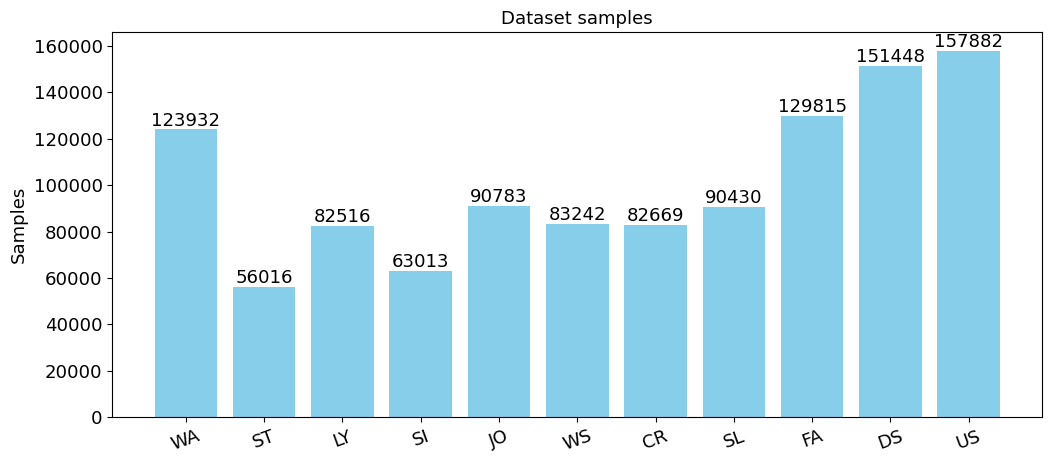

In [222]:
w_Walking  = []; w_Standing = []; w_Lying = []; w_Sitting= []; w_Jogging = []; w_WalkStoop = []; w_Crawling= [];  w_Slithering =[]; w_Falling =[] ; w_DownStair = []; w_UpStair =[]
# class_names = ['walking','Standing', 'Lying', 'Sitting','Jogging','WalkStoop','Crawling','Slithering','Falling', 'Downstair', 'Upstair']
class_names = ['WA','ST', 'LY', 'SI','JO','WS','CR','SL','FA', 'DS', 'US']
_columns = ['timestamp', 'Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z']
n_sample =np.zeros(11)

# Danh sách các đường dẫn có thể
possible_dirs = [
    'G:/My Drive/NCSHieu/linh cuu hoa/dataset/DatasetFireFighters/',
    'D:/NCSHieuServer/My Drive/NCSHieu/linh cuu hoa/dataset/DatasetFireFighters/',
    'C:/Users/Pi/My Drive/NCSHieu/linh cuu hoa/dataset/DatasetFireFighters/'
]
# Tìm đường dẫn tồn tại đầu tiên
_dir = next((d for d in possible_dirs if os.path.exists(d)), None)

def extract_peak_segment_with_noise_padding(df):
    acc_mag = np.sqrt(df['Acc_X']**2 + df['Acc_Y']**2 + df['Acc_Z']**2)
    peak_idx = acc_mag.idxmax()

    left_size = 150
    right_size = 149

    start_idx = peak_idx - left_size
    end_idx = peak_idx + right_size + 1

    left_part = df.iloc[max(0, start_idx):peak_idx]
    peak_row = df.iloc[[peak_idx]]
    right_part = df.iloc[peak_idx + 1:min(len(df), end_idx)]

    def generate_noisy_samples(ref_df, num_samples):
        mean = ref_df.mean(numeric_only=True)
        numeric_cols = mean.index
        noise = np.random.uniform(-0.05, 0.05, size=(num_samples, len(numeric_cols)))
        samples = mean.values + noise
        gen_df = pd.DataFrame(samples, columns=numeric_cols)

        # Xử lý cột không phải số (vd: timestamp)
        for col in df.columns:
            if col not in numeric_cols:
                gen_df[col] = np.nan
        return gen_df[df.columns]

    # Padding trái
    if len(left_part) < left_size:
        pad_count = left_size - len(left_part)
        pad_data = generate_noisy_samples(df.iloc[:20], pad_count)
        left_part = pd.concat([pad_data, left_part], ignore_index=True)

    # Padding phải
    if len(right_part) < right_size:
        pad_count = right_size - len(right_part)
        pad_data = generate_noisy_samples(df.iloc[-20:], pad_count)
        right_part = pd.concat([right_part, pad_data], ignore_index=True)

    segment = pd.concat([left_part, peak_row, right_part], ignore_index=True)

    return segment
window_size = 3*50
stride = 3*50
for root, dirs, files in os.walk(_dir):
    # Lọc để chỉ lấy các file TXT trong thư mục
    txt_files = [f for f in files if f.endswith('.txt') or f.endswith('.TXT')]
    for filename in txt_files:
        file_path = os.path.join(root, filename)
        data = pd.read_csv(file_path, names=_columns)
        data['Gyr_Z'] =data['Gyr_Z'].str.replace(';', '')
        data = data.dropna()
        for column in _columns:
            data[column] = pd.to_numeric(data[column], errors='coerce')
        # # tức là cứ 2 mẫu thì lấy 1)
        data = data.groupby(data.index // 2).mean().reset_index(drop=True)
        data = data[['Acc_X', 'Acc_Y', 'Acc_Z']]
        # Nếu là hành động ngã thì mỗi file là 1 cửa sổ   
        if filename.startswith('8'):
            # print(f"{filename}: W_Falling")
            w_data = extract_peak_segment_with_noise_padding(data)
            w_Falling.append(w_data)
            n_sample[8]=n_sample[8]+len(data)
        #các hành động còn lại thì chia đều theo kích thước cửa sổ
        else:
            w_data= [data[i:i+window_size].reset_index(drop=True) for i in range(0, int(len(data)), stride) if i+window_size<=int(len(data))]
            if filename.startswith('0'):
                # print(f"{filename}: w_Walking")
                w_Walking  = w_Walking+ w_data
                n_sample[0]=n_sample[0]+len(data)
            elif filename.startswith('1'):
                # print(f"{filename}: w_Standing")
                w_Standing  = w_Standing+ w_data
                n_sample[1]=n_sample[1]+len(data)

            elif filename.startswith('2'):
                # print(f"{filename}: w_Lying")
                w_Lying  = w_Lying+ w_data
                n_sample[2]=n_sample[2]+len(data)

            elif filename.startswith('3'):
                # print(f"{filename}: w_Sitting")
                w_Sitting  = w_Sitting+ w_data
                n_sample[3]=n_sample[3]+len(data)

            elif filename.startswith('4'):
                # print(f"{filename}: w_Jogging")
                w_Jogging  = w_Jogging+ w_data
                n_sample[4]=n_sample[4]+len(data)

            elif filename.startswith('5'):
                # print(f"{filename}: w_WalkStoop")
                w_WalkStoop  = w_WalkStoop+ w_data
                n_sample[5]=n_sample[5]+len(data)

            elif filename.startswith('6'):
                # print(f"{filename}: w_Crawling")
                w_Crawling  = w_Crawling+ w_data
                n_sample[6]=n_sample[6]+len(data)


            elif filename.startswith('7'):
                # print(f"{filename}: w_Slithering")
                w_Slithering  = w_Slithering+ w_data
                n_sample[7]=n_sample[7]+len(data)

            elif filename.startswith('9'):
                # print(f"{filename}: w_DownStair")
                w_DownStair  = w_DownStair+ w_data
                n_sample[9]=n_sample[9]+len(data)

            elif filename.startswith('i.'):
                # print(f"{filename}: w_UpStair")
                w_UpStair  = w_UpStair+ w_data 
                n_sample[10]=n_sample[10]+len(data)

# Thiết lập nhãn cho các cột (tùy chọn)
labels = [class_names[i] for i in range(len(n_sample))]
plt.figure(figsize=(12, 5))
# Vẽ biểu đồ cột
plt.xticks(rotation=20, fontsize=13)
plt.yticks(fontsize=13)
plt.bar(labels, n_sample, color='skyblue')
# Thêm chỉ số lên đầu mỗi cột
for i, value in enumerate(n_sample):
    plt.text(i, value, str(int(value)), ha='center', va='bottom',fontsize=13)
plt.ylabel('Samples',fontsize=13)
plt.title('Dataset samples',fontsize=13)
plt.show()

Tạo tập train và test ban đầu

In [223]:
data_train= []
label_train = []
data_test= []
label_test = []
train_features = []
test_features = []
final_features = []
RateTrain = 0.6
ratestate=22
test_Walking, train_Walking = train_test_split(w_Walking, test_size=RateTrain,random_state=ratestate)
test_Standing, train_Standing = train_test_split(w_Standing, test_size=RateTrain,random_state=ratestate)
test_Lying, train_Lying = train_test_split(w_Lying, test_size=RateTrain,random_state=ratestate)
test_Sitting, train_Sitting = train_test_split(w_Sitting, test_size=RateTrain,random_state=ratestate)
test_Jogging, train_Jogging = train_test_split(w_Jogging, test_size=RateTrain,random_state=ratestate)
test_WalkStoop, train_WalkStoop = train_test_split(w_WalkStoop, test_size=RateTrain,random_state=ratestate)
test_Crawling, train_Crawling = train_test_split(w_Crawling, test_size=RateTrain,random_state=ratestate)
test_Slithering, train_Slithering = train_test_split(w_Slithering, test_size=RateTrain,random_state=ratestate)
test_Falling, train_Falling = train_test_split(w_Falling, test_size=RateTrain,random_state=ratestate)
test_DownStair, train_DownStair = train_test_split(w_DownStair, test_size=RateTrain,random_state=ratestate)
test_UpStair, train_UpStair = train_test_split(w_UpStair, test_size=RateTrain,random_state=ratestate)      

for acts in train_Walking:
    data_train.append(pd.DataFrame(acts))
    label_train.append(0)

for acts in train_Standing:
    data_train.append(pd.DataFrame(acts))
    label_train.append(1)

for acts in train_Lying:
    data_train.append(pd.DataFrame(acts))
    label_train.append(2)

for acts in train_Sitting:
    data_train.append(pd.DataFrame(acts))
    label_train.append(3)

for acts in train_Jogging:
    data_train.append(pd.DataFrame(acts))
    label_train.append(4)

for acts in train_WalkStoop:
    data_train.append(pd.DataFrame(acts))
    label_train.append(5)

for acts in train_Crawling:
    data_train.append(pd.DataFrame(acts))
    label_train.append(6)

for acts in train_Slithering:
    data_train.append(pd.DataFrame(acts))
    label_train.append(7)

for acts in train_Falling:
    data_train.append(pd.DataFrame(acts))
    label_train.append(8)

for acts in train_DownStair:
    data_train.append(pd.DataFrame(acts))
    label_train.append(9)

for acts in train_UpStair:
    data_train.append(pd.DataFrame(acts))
    label_train.append(10)

for acts in test_Walking:
    data_test.append(pd.DataFrame(acts))
    label_test.append(0)

for acts in test_Standing:
    data_test.append(pd.DataFrame(acts))
    label_test.append(1)

for acts in test_Lying:
    data_test.append(pd.DataFrame(acts))
    label_test.append(2)

for acts in test_Sitting:
    data_test.append(pd.DataFrame(acts))
    label_test.append(3)

for acts in test_Jogging:
    data_test.append(pd.DataFrame(acts))
    label_test.append(4)

for acts in test_WalkStoop:
    data_test.append(pd.DataFrame(acts))
    label_test.append(5)

for acts in test_Crawling:
    data_test.append(pd.DataFrame(acts))
    label_test.append(6)

for acts in test_Slithering:
    data_test.append(pd.DataFrame(acts))
    label_test.append(7)

for acts in test_Falling:
    data_test.append(pd.DataFrame(acts))
    label_test.append(8)

for acts in test_DownStair:
    data_test.append(pd.DataFrame(acts))
    label_test.append(9)

for acts in test_UpStair:
    data_test.append(pd.DataFrame(acts))
    label_test.append(10)

for action in data_train:
    feat = featuresFromBuffer(action)
    train_features.append(feat)
for action in data_test:
    feat = featuresFromBuffer(action)
    test_features.append(feat) 

Tìm tham số tối ưu

In [51]:
max_score = 0
iteration = 0  # Đếm số lần lặp
target_score = 97.3  # Ngưỡng độ chính xác

print(f"Iteration Training model...")

#============
param_dist = {
    '_estimators': range(12, 20, 1),  # Số lượng cây từ 10 đến 20
    '_depth': range(10, 16,1),      # Độ sâu tối đa từ 10 đến 30
    '_random':range(1,100,1)       # ngau nhien 1:30
}

# Khởi tạo một DataFrame để lưu kết quả
results = []
_score = 0
# Thực hiện Grid Search thủ công
for _estimators in param_dist['_estimators']:
    for _depth in param_dist['_depth']:
        for _random in param_dist['_random']:
            # Huấn luyện mô hình với tham số hiện tại
            clf4 = RandomForestClassifier(criterion='entropy',n_jobs=-1, n_estimators=_estimators, max_depth=_depth,max_features='sqrt',class_weight='balanced', 
                                            ccp_alpha=0.0005, warm_start=False,
                                            bootstrap=True, random_state=_random).fit(train_features, label_train)
            
            # Dự đoán trên tập kiểm tra
            predicted_RF = clf4.predict(test_features)
            
            # Tính toán độ chính xác
            score = clf4.score(test_features, label_test)
            
            if _score < score:
                _score = score
                print("n_estimators=" , _estimators, "; max_depth= " , _depth, "; random_state= " , _random)
                print(f"Accuracy of RF classifier on test set: {round(score * 100, 1)}")
                def model_size_in_bytes(model):
                    return len(pickle.dumps(model))
                print(f"Model size (MB): {round(model_size_in_bytes(clf4)/1024**2, 3)}")

            # Lưu kết quả
            results.append({'n_estimators': _estimators, 'max_depth': _depth, 'random_state': _random, 'score': round(score * 100, 1)})
            if _score>= target_score:
                break 
            
results_df = pd.DataFrame(results)

# Tìm giá trị score cao nhất
max_score = results_df['score'].max()


# Lưu kết quả tốt nhất
high_score_df = results_df[results_df['score'] == max_score]
if len(high_score_df) > 0:
    best_params = high_score_df.iloc[0]
else:
    best_params = None



results_df.to_csv(_dir+"search_results_BestFeature.csv", index=False)





Iteration Training model...
n_estimators= 12 ; max_depth=  10 ; random_state=  1
Accuracy of RF classifier on test set: 94.7
Model size (MB): 0.406
n_estimators= 12 ; max_depth=  10 ; random_state=  6
Accuracy of RF classifier on test set: 95.0
Model size (MB): 0.442
n_estimators= 12 ; max_depth=  10 ; random_state=  8
Accuracy of RF classifier on test set: 95.1
Model size (MB): 0.413
n_estimators= 12 ; max_depth=  11 ; random_state=  9
Accuracy of RF classifier on test set: 95.2
Model size (MB): 0.504
n_estimators= 12 ; max_depth=  11 ; random_state=  10
Accuracy of RF classifier on test set: 95.4
Model size (MB): 0.522
n_estimators= 12 ; max_depth=  11 ; random_state=  40
Accuracy of RF classifier on test set: 95.5
Model size (MB): 0.493
n_estimators= 12 ; max_depth=  11 ; random_state=  78
Accuracy of RF classifier on test set: 95.6
Model size (MB): 0.508
n_estimators= 12 ; max_depth=  12 ; random_state=  9
Accuracy of RF classifier on test set: 95.7
Model size (MB): 0.576
n_estimat

mô hình với siêu tham số tối ưu

In [224]:
best_params

n_estimators    17.0
max_depth       14.0
random_state    31.0
score           96.4
Name: 3396, dtype: float64

In [404]:
#features  Tuyên
def featuresFromBufferN(at):
    feat = np.zeros(15)   
    ax = np.array(at['Acc_X'], dtype=np.float64)
    ay = np.array(at['Acc_Y'], dtype=np.float64)
    az = np.array(at['Acc_Z'], dtype=np.float64)
    mag = np.sqrt(ax**2+ay**2+az**2)-1
    # Interquartile Range
    iqr_val = [np.percentile(i, 75) - np.percentile(i, 25) for i in [ax, ay, az]]
    feat[0:3] = iqr_val

    # Energy
    energy_acc = [np.sqrt(np.mean(i**2)) for i in [ax, ay, az]]
    feat[3:6] = energy_acc

    # Standard Deviation (std)
    std_acc = [np.std(i) for i in [ax, ay, az]]
    feat[6:9] = std_acc

    # Range
    Range_acc = [np.amax(i) - np.amin(i) for i in [ax, ay, az]]
    feat[9:12] = Range_acc

    # AAD
    mad_acc = [np.mean(i - np.mean(i)) for i in [ax, ay, az]]
    feat[12:15] = mad_acc
    
    return feat
train_featuresT=[]
for action in data_train:
    feat = featuresFromBufferN(action)
    train_featuresT.append(feat)
test_featuresT=[]
for action in data_test:
    feat = featuresFromBufferN(action)
    test_featuresT.append(feat) 
    
clf4T = RandomForestClassifier(criterion='entropy',class_weight='balanced', 
    n_estimators=int(best_params['n_estimators']), # Số lượng cây trong rừng (default=100)
    max_depth=int(best_params['max_depth']), # Độ sâu tối đa của cây (default=None, grow until all leaves are pure)
    max_features='sqrt', # Số đặc trưng tối đa được xem xét khi tách (default='sqrt')
    bootstrap=True, # Có sử dụng bootstrap hay không (default=True)
    n_jobs=-1, # Số luồng thực thi song song (-1 để sử dụng tất cả CPU, default=None)
    ccp_alpha=0.015, warm_start=False,
    random_state=36).fit(train_featuresT, label_train)
# Đánh giá mô hình
predicted_1 = clf4T.predict(test_featuresT)
from sklearn.metrics import f1_score
test_accuracy=f1_score(label_test,predicted_1,average='macro')
print(f"F1 macro features Tuyen: {round(test_accuracy * 100, 1)}")

F1 macro features Tuyen: 88.3


In [405]:
#features  Nhung
def featuresFromBufferN(at):
    feat = np.zeros(15)   
    ax = np.array(at['Acc_X'], dtype=np.float64)
    ay = np.array(at['Acc_Y'], dtype=np.float64)
    az = np.array(at['Acc_Z'], dtype=np.float64)
    mag = np.sqrt(ax**2+ay**2+az**2)-1
    # Interquartile Range
    mean_acc = [np.mean(i) for i in [ax, ay, az]]
    feat[0:3] = mean_acc

    # Energy
    energy_acc = [np.sqrt(np.mean(i**2)) for i in [ax, ay, az]]
    feat[3:6] = energy_acc

    # Standard Deviation (std)
    std_acc = [np.std(i) for i in [ax, ay, az]]
    feat[6:9] = std_acc

    # Range
    Range_acc = [np.amax(i) - np.amin(i) for i in [ax, ay, az]]
    feat[9:12] = Range_acc

    # AAD
    median_acc = [np.median(i) for i in [ax, ay, az]]
    feat[12:15] = median_acc
    
    return feat
train_featuresT=[]
for action in data_train:
    feat = featuresFromBufferN(action)
    train_featuresT.append(feat)
test_featuresT=[]
for action in data_test:
    feat = featuresFromBufferN(action)
    test_featuresT.append(feat) 
    
clf4T = RandomForestClassifier(criterion='entropy',class_weight='balanced', 
    n_estimators=int(best_params['n_estimators']), # Số lượng cây trong rừng (default=100)
    max_depth=int(best_params['max_depth']), # Độ sâu tối đa của cây (default=None, grow until all leaves are pure)
    max_features='sqrt', # Số đặc trưng tối đa được xem xét khi tách (default='sqrt')
    bootstrap=True, # Có sử dụng bootstrap hay không (default=True)
    n_jobs=-1, # Số luồng thực thi song song (-1 để sử dụng tất cả CPU, default=None)
    ccp_alpha=0.02, warm_start=False,
    random_state=1).fit(train_featuresT, label_train)
# Đánh giá mô hình
predicted_1 = clf4T.predict(test_featuresT)
from sklearn.metrics import f1_score
test_accuracy=f1_score(label_test,predicted_1,average='macro')
print(f"F1 macro features Nhung: {round(test_accuracy * 100, 1)}")

F1 macro features Nhung: 86.1


In [391]:
#features  Wang
import numpy as np
from scipy.stats import entropy
from scipy.fft import fft

def featuresFromBufferN(at):
    ax = np.array(at['Acc_X'], dtype=np.float64)
    ay = np.array(at['Acc_Y'], dtype=np.float64)
    az = np.array(at['Acc_Z'], dtype=np.float64)

    feat = []

    # Mean
    feat.extend([np.mean(i) for i in [ax, ay, az]])

    # Standard deviation (SD)
    feat.extend([np.std(i) for i in [ax, ay, az]])

    # Covariance (pairwise)
    feat.append(np.cov(ax, ay)[0, 1])
    feat.append(np.cov(ax, az)[0, 1])
    feat.append(np.cov(ay, az)[0, 1])

    # Variance
    feat.extend([np.var(i) for i in [ax, ay, az]])

    # Min & Max
    feat.extend([np.min(i) for i in [ax, ay, az]])
    feat.extend([np.max(i) for i in [ax, ay, az]])

    # Correlation coefficients
    feat.append(np.corrcoef(ax, ay)[0, 1])
    feat.append(np.corrcoef(ax, az)[0, 1])
    feat.append(np.corrcoef(ay, az)[0, 1])

    # RMS (Root Mean Square)
    feat.extend([np.sqrt(np.mean(i**2)) for i in [ax, ay, az]])

    # Signal Magnitude Vector (SMV)
    smv = np.mean(np.sqrt(ax**2 + ay**2 + az**2))
    feat.append(smv)

    # Frequency domain features
    for i in [ax, ay, az]:
        f = np.abs(fft(i))
        energy = np.sum(f**2) / len(f)
        norm_f = f / np.sum(f) if np.sum(f) != 0 else f
        ent = entropy(norm_f)
        feat.extend([energy, ent])

    return np.array(feat)
train_featuresT=[]
for action in data_train:
    feat = featuresFromBufferN(action)
    train_featuresT.append(feat)
test_featuresT=[]
for action in data_test:
    feat = featuresFromBufferN(action)
    test_featuresT.append(feat) 
    
clf4T = RandomForestClassifier(criterion='entropy',class_weight='balanced', 
    n_estimators=int(best_params['n_estimators']), # Số lượng cây trong rừng (default=100)
    max_depth=int(best_params['max_depth']), # Độ sâu tối đa của cây (default=None, grow until all leaves are pure)
    max_features='sqrt', # Số đặc trưng tối đa được xem xét khi tách (default='sqrt')
    bootstrap=True, # Có sử dụng bootstrap hay không (default=True)
    n_jobs=-1, # Số luồng thực thi song song (-1 để sử dụng tất cả CPU, default=None)
    ccp_alpha=0.005, warm_start=False,
    random_state=22).fit(train_featuresT, label_train)
# Đánh giá mô hình
predicted_1 = clf4T.predict(test_featuresT)
from sklearn.metrics import f1_score
test_accuracy=f1_score(label_test,predicted_1,average='macro')
print(f"F1 macro features Wang: {round(test_accuracy * 100, 1)}")

F1 macro features Wang: 94.5


In [387]:
#Features Chai
import numpy as np
from scipy.stats import skew, kurtosis, entropy
from scipy.signal import welch
from scipy.fft import fft
from numpy.linalg import lstsq

def hjorth_parameters(signal):
    """Compute Hjorth mobility and complexity."""
    first_deriv = np.diff(signal)
    second_deriv = np.diff(first_deriv)
    var_zero = np.var(signal)
    var_d1 = np.var(first_deriv)
    var_d2 = np.var(second_deriv)
    mobility = np.sqrt(var_d1 / var_zero) if var_zero != 0 else 0
    complexity = np.sqrt(var_d2 / var_d1) / mobility if var_d1 != 0 and mobility != 0 else 0
    return mobility, complexity

def arc(signal, order=4):
    """Auto-regressive coefficients using Yule-Walker equations."""
    X = np.column_stack([np.roll(signal, -i) for i in range(1, order + 1)])
    X = X[:-order]
    y = signal[order:]
    coeffs, _, _, _ = lstsq(X, y, rcond=None)
    return coeffs

def frequency_features(signal, fs=50):
    N = len(signal)
    f = np.abs(fft(signal))
    f = f[:N // 2]  # Chỉ lấy nửa phổ (1 chiều)
    freqs = np.fft.fftfreq(N, d=1/fs)[:N // 2]

    power = f ** 2
    total_power = np.sum(power)
    if total_power == 0:
        total_power = 1e-10  # prevent division by 0

    mnf = np.sum(freqs * power) / total_power
    mdf = freqs[np.argmax(np.cumsum(power) >= total_power / 2)]
    peak_height = np.max(power)
    pf = freqs[np.argmax(power)]
    vcf = np.sum(((freqs - mnf) ** 2) * power) / total_power

    return [mnf, mdf, peak_height, pf, total_power, vcf]

def featuresFromBufferN(at):
    feat = []
    for axis in ['Acc_X', 'Acc_Y', 'Acc_Z']:
        data = np.array(at[axis], dtype=np.float64)
        N = len(data)
        diff_data = np.diff(data)
        abs_diff_data = np.abs(diff_data)

        # Time domain features
        feat.append(np.mean(data))                           # Mean
        feat.append(np.std(data))                            # STD
        feat.append(np.max(data) - np.min(data))             # Range
        feat.append(np.mean(np.abs(data - np.mean(data))))   # Mean Absolute Deviation
        feat.append(np.median(np.abs(data - np.median(data))))  # Median Absolute Deviation
        feat.append(np.mean(np.abs(data)))                   # Mean Absolute Value
        feat.append(np.sum(data**2))                         # Simple Square Integral
        feat.append(np.sqrt(np.mean(data**2)))               # RMS
        feat.append(np.mean(abs_diff_data))                  # Average Amplitude Change
        feat.append(np.linalg.norm(data))                    # L2norm
        feat.append(np.sqrt(np.sum(np.square(data - np.mean(data))) / (N - 1)))  # L-scale
        feat.append(np.mean(np.abs(np.std(data) - np.std(abs_diff_data))))  # DASTD
        feat.append(np.percentile(data, 75) - np.percentile(data, 25))  # IQR
        feat.append(skew(data))                              # Skewness
        feat.append(np.sum(np.abs(data)))                    # SMA (rough approx)
        feat.append(kurtosis(data))                          # Kurtosis
        feat.append(np.corrcoef(data[:-1], data[1:])[0, 1])  # Autocorrelation (lag=1)
        feat.extend(arc(data))                               # Auto-regressive Coeffs (order 4)
        hjm, hjc = hjorth_parameters(data)                   # Hjorth parameters
        feat.extend([hjm, hjc])

        # Frequency domain features
        feat.extend(frequency_features(data))

    return np.array(feat)
train_featuresT=[]
for action in data_train:
    feat = featuresFromBufferN(action)
    train_featuresT.append(feat)
test_featuresT=[]
for action in data_test:
    feat = featuresFromBufferN(action)
    test_featuresT.append(feat) 
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import f1_score
clf4T = RandomForestClassifier(criterion='entropy',class_weight='balanced', 
    n_estimators=int(best_params['n_estimators']), # Số lượng cây trong rừng (default=100)
    max_depth=int(best_params['max_depth']), # Độ sâu tối đa của cây (default=None, grow until all leaves are pure)
    max_features='sqrt', # Số đặc trưng tối đa được xem xét khi tách (default='sqrt')
    bootstrap=True, # Có sử dụng bootstrap hay không (default=True)
    n_jobs=-1, # Số luồng thực thi song song (-1 để sử dụng tất cả CPU, default=None)
    ccp_alpha=0.0005, warm_start=False,
    random_state=22).fit(train_featuresT, label_train)
# Đánh giá mô hình
predicted_1 = clf4T.predict(test_featuresT)
test_accuracy=f1_score(label_test,predicted_1,average='macro')
print(f"F1 macro features Chai: {round(test_accuracy * 100, 1)}")

F1 macro features Chai: 96.6


Accuracy of RF classifier on training set: 99.8
Accuracy of RF classifier on test set: 96.4
Model size (MB): 0.928


<Axes: >

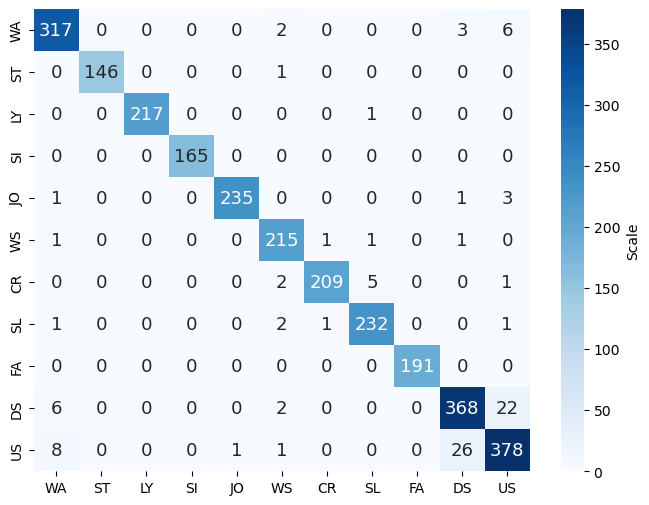

In [238]:
clf4 = RandomForestClassifier(criterion='entropy',class_weight='balanced', 
    n_estimators=int(best_params['n_estimators']), # Số lượng cây trong rừng (default=100)
    max_depth=int(best_params['max_depth']), # Độ sâu tối đa của cây (default=None, grow until all leaves are pure)
    max_features='sqrt', # Số đặc trưng tối đa được xem xét khi tách (default='sqrt')
    bootstrap=True, # Có sử dụng bootstrap hay không (default=True)
    n_jobs=-1, # Số luồng thực thi song song (-1 để sử dụng tất cả CPU, default=None)
    ccp_alpha=0.0005, warm_start=False,
    random_state=int(best_params['random_state'])).fit(train_features, label_train)
# Đánh giá mô hình
train_accuracy = clf4.score(train_features, label_train)
test_accuracy = clf4.score(test_features, label_test)

print(f"Accuracy of RF classifier on training set: {round(train_accuracy * 100, 1)}")
print(f"Accuracy of RF classifier on test set: {round(test_accuracy * 100, 1)}")
def model_size_in_bytes(model):
    return len(pickle.dumps(model))
print(f"Model size (MB): {round(model_size_in_bytes(clf4)/1024**2, 3)}")
# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
_pred = clf4.predict(test_features)
_conf_matrix = confusion_matrix(label_test, _pred)
sns.heatmap(_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, cbar_kws={'label': 'Scale'}, annot_kws={"size": 13})

Lưu/load model đã build với các tham số tối ưu

In [229]:
# try:
#     # Đọc lại mô hình và dữ liệu từ file
#     total_model = joblib.load(_dir + 'total_model.pkl')
#     results_model = pd.read_csv(_dir + "results_model.csv")
#     dfresultDelFeature = joblib.load(_dir + 'dfresultDelFeature.pkl')
#     sRF_new = joblib.load(_dir + 'random_forest_model.pkl')
#     train_features = joblib.load(_dir + 'train_features.pkl')
#     test_features = joblib.load(_dir + 'test_features.pkl')
#     label_test = joblib.load(_dir + 'label_test_Server.pkl')
#     label_train = joblib.load(_dir + 'label_train_Server.pkl')
#     best_params = joblib.load(_dir + 'best_params.pkl')
#     final_features = joblib.load(_dir + 'final_features.pkl')
#     X_train_reduced = joblib.load(_dir + 'X_train_reduced.pkl')
#     X_test_reduced = joblib.load(_dir + 'X_test_reduced.pkl')
#     print("✅ Đã đọc lại toàn bộ mô hình và dữ liệu.")
# except Exception as e:
#     print(f"❌ Không thể đọc dữ liệu. Lỗi: {e}")


# def model_size_in_bytes(model):
#     return len(pickle.dumps(model))

✅ Đã đọc lại toàn bộ mô hình và dữ liệu.


Tối ưu hoá đặc trưng và lưu lại


Standard deviation of importance scores (including removed and remaining features): 0.0228

 Mean of importance scores (including removed and remaining features): 0.0231


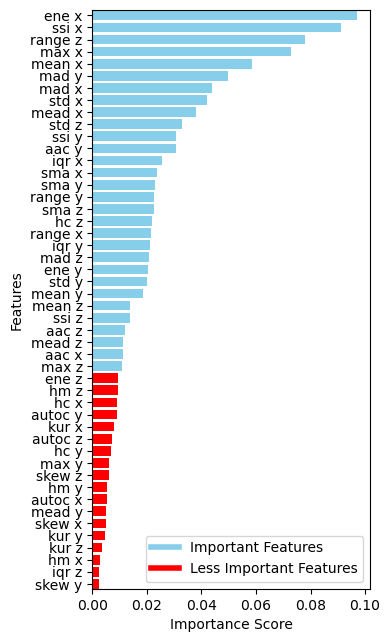


Final remaining features:
['max x', 'ssi x', 'range z', 'mad x', 'ene x', 'mad z', 'mean x', 'aac y', 'std x', 'sma x', 'std y', 'mead z', 'mead x', 'ene y', 'std z', 'mean y', 'mad y', 'iqr y', 'iqr x', 'ssi z', 'mean z', 'range x', 'max z', 'hc z', 'aac z', 'sma z', 'sma y', 'aac x', 'range y', 'ssi y']


In [231]:
X_train_reduced=[];X_test_reduced=[]
X_train_reduced, X_test_reduced, final_features= feature_selection_with_rf(clf4,
    train_features, test_features, label_train, Feature_name_ , threshold=0.01)


Tái lặp ngẫu nhiên để lựa chọn tối ưu kết quả

In [73]:
max_score = 0
iteration = 0  # Đếm số lần lặp
target_score = 97.3  # Ngưỡng độ chính xác
best_random = 0
print(f"Iteration Training model...")

#============
param_dist = {
    '_random':range(1,200,1)       # ngau nhien 1:30
}

# Khởi tạo một DataFrame để lưu kết quả
results = []
_score = 0
# Thực hiện Grid Search thủ công

for _random in param_dist['_random']:
    # Huấn luyện mô hình với tham số hiện tại
    clf4 = RandomForestClassifier(criterion='entropy',
    class_weight='balanced', 
    n_estimators=int(best_params['n_estimators']), # Số lượng cây trong rừng (default=100)
    max_depth=int(best_params['max_depth']), # Độ sâu tối đa của cây (default=None, grow until all leaves are pure)
    max_features='sqrt', # Số đặc trưng tối đa được xem xét khi tách (default='sqrt')
    bootstrap=True, # Có sử dụng bootstrap hay không (default=True)
    n_jobs=-1, # Số luồng thực thi song song (-1 để sử dụng tất cả CPU, default=None)
    ccp_alpha=0.0005, warm_start=False,
    random_state=_random).fit(X_train_reduced, label_train)
    
    # Tính toán độ chính xác
    score = clf4.score(X_test_reduced, label_test)
    
    if _score < score:
        _score = score
        best_random = _random
        print("random_state= " , _random)
        print(f"Accuracy of RF classifier on test set: {round(score * 100, 1)}")
        print(f"Model size (MB): {round(model_size_in_bytes(clf4)/1024**2, 3)}")

    # del clf4
            





Iteration Training model...
random_state=  1
Accuracy of RF classifier on test set: 95.5
Model size (MB): 0.931
random_state=  2
Accuracy of RF classifier on test set: 95.6
Model size (MB): 0.927
random_state=  8
Accuracy of RF classifier on test set: 95.6
Model size (MB): 0.954
random_state=  11
Accuracy of RF classifier on test set: 95.7
Model size (MB): 0.946
random_state=  15
Accuracy of RF classifier on test set: 95.7
Model size (MB): 0.948
random_state=  22
Accuracy of RF classifier on test set: 96.1
Model size (MB): 0.922
random_state=  45
Accuracy of RF classifier on test set: 96.3
Model size (MB): 0.944


Thử lại mô hình sau khi rút gọn đặc trưng

In [ ]:
def featuresFromBufferNew(at):
    feat_dict = {}
    ax = np.array(at['Acc_X'], dtype=np.float64)
    ay = np.array(at['Acc_Y'], dtype=np.float64)
    az = np.array(at['Acc_Z'], dtype=np.float64)
    # Tính toàn bộ đặc trưng cần thiết theo trục
    feat_dict['Max x'] = np.max(ax)
    feat_dict['SSI x'] = np.sum(ax ** 2)
    feat_dict['Range z'] = np.max(az) - np.min(az)
    feat_dict['MAD x'] = np.mean(np.abs(ax - np.mean(ax)))
    feat_dict['Ene x'] = np.sqrt(np.mean(ax ** 2))
    feat_dict['MAD z'] = np.mean(np.abs(az - np.mean(az)))
    feat_dict['Mean x'] = np.mean(ax)
    feat_dict['aac y'] = np.mean(np.abs(np.diff(ay)))
    feat_dict['Std x'] = np.std(ax)
    feat_dict['SMA x'] = np.sum(np.abs(ax))
    feat_dict['Std y'] = np.std(ay)
    feat_dict['MeaD z'] = np.median(np.abs(az - np.median(az)))
    feat_dict['MeaD x'] = np.median(np.abs(ax - np.median(ax)))
    feat_dict['Ene y'] = np.sqrt(np.mean(ay ** 2))
    feat_dict['Std z'] = np.std(az)
    feat_dict['Mean y'] = np.mean(ay)
    feat_dict['MAD y'] = np.mean(np.abs(ay - np.mean(ay)))
    feat_dict['IQR y'] = np.percentile(ay, 75) - np.percentile(ay, 25)
    feat_dict['IQR x'] = np.percentile(ax, 75) - np.percentile(ax, 25)
    feat_dict['SSI z'] = np.sum(az ** 2)
    feat_dict['Mean z'] = np.mean(az)
    feat_dict['Range x'] = np.max(ax) - np.min(ax)
    feat_dict['Max z'] = np.max(az)
    feat_dict['hc z'] = (
        (np.sqrt(np.var(np.diff(np.diff(az))) / np.var(np.diff(az))) /
         np.sqrt(np.var(np.diff(az)) / np.var(az)))
    )
    feat_dict['aac z'] = np.mean(np.abs(np.diff(az)))
    feat_dict['SMA z'] = np.sum(np.abs(az))
    feat_dict['SMA y'] = np.sum(np.abs(ay))
    feat_dict['aac x'] = np.mean(np.abs(np.diff(ax)))
    feat_dict['Range y'] = np.max(ay) - np.min(ay)
    feat_dict['SSI y'] = np.sum(ay ** 2)

    # Trả về đặc trưng theo đúng thứ tự mong muốn
    feature_order = [
        'Max x', 'SSI x', 'Range z', 'MAD x', 'Ene x', 'MAD z', 'Mean x', 'aac y',
        'Std x', 'SMA x', 'Std y', 'MeaD z', 'MeaD x', 'Ene y', 'Std z', 'Mean y',
        'MAD y', 'IQR y', 'IQR x', 'SSI z', 'Mean z', 'Range x', 'Max z', 'hc z',
        'aac z', 'SMA z', 'SMA y', 'aac x', 'Range y', 'SSI y'
    ]
    
    feat = np.array([feat_dict[f] for f in feature_order])
    return feat
train_featuresNew = []
for action in data_train:
    feat = featuresFromBufferNew(action)
    train_featuresNew.append(feat)

test_featuresNew =[]
for action in data_test:
    feat = featuresFromBufferNew(action)
    test_featuresNew.append(feat)
RF_new = RandomForestClassifier(criterion='entropy',class_weight='balanced', 
    n_estimators=17, # Số lượng cây trong rừng (default=100)
    max_depth=14, # Độ sâu tối đa của cây (default=None, grow until all leaves are pure)
    max_features='sqrt', # Số đặc trưng tối đa được xem xét khi tách (default='sqrt')
    bootstrap=True, # Có sử dụng bootstrap hay không (default=True)
    n_jobs=-1, # Số luồng thực thi song song (-1 để sử dụng tất cả CPU, default=None)
    ccp_alpha=0.0005, 
    warm_start=False,    
    random_state=22).fit(train_featuresNew, label_train)
# Đánh giá mô hình
train_accuracy = RF_new.score(train_featuresNew, label_train)
test_accuracy = RF_new.score(test_featuresNew, label_test)
print(f"Accuracy of RF classifier on training set: {round(train_accuracy * 100, 1)}")
print(f"Accuracy of RF classifier on test set: {round(test_accuracy * 100, 1)}")
def model_size_in_bytes(model):
    return len(pickle.dumps(model))
print(f"Model size (MB): {round(model_size_in_bytes(RF_new)/1024**2, 3)}")
test_predict = RF_new.predict(test_featuresNew)
best_conf_matrix=confusion_matrix(label_test,test_predict)
plt.figure(figsize=(6, 6))
sns.heatmap(best_conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names,
            cbar=False, annot_kws={"size": 18})

# Set labels and title with font size 14
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True', fontsize=18)
plt.title('(a) RF on private dataset',fontsize=18)
# Rotate x-axis labels by 30 degrees
plt.xticks(rotation=30, fontsize=18)
plt.yticks(rotation=30, fontsize=18)

# Show plot
plt.show()

Accuracy of RF classifier on training set: 99.6
Accuracy of RF classifier on test set: 96.1
Model size (MB): 0.922


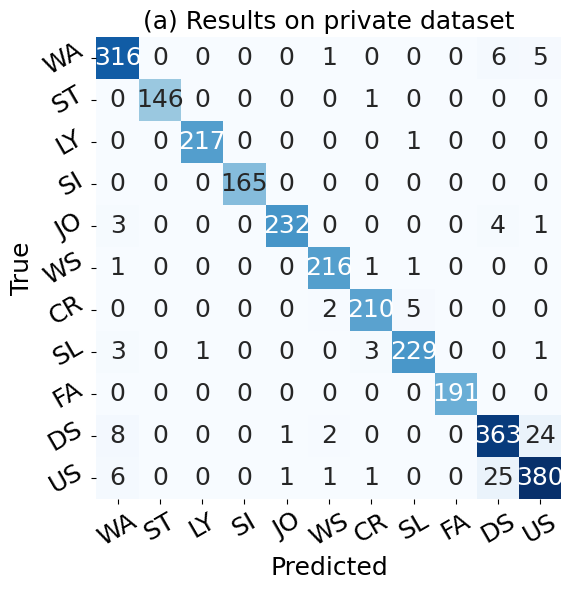

,Activity,Acc,Sen,Spe,Pre,F1
0,WA,98.8,96.3,99.1,93.8,95.0
1,ST,100.0,99.3,100.0,100.0,99.7
2,LY,99.9,99.5,100.0,99.5,99.5
3,SI,100.0,100.0,100.0,100.0,100.0
4,JO,99.6,96.7,99.9,99.1,97.9
5,WS,99.7,98.6,99.8,97.3,98.0
6,CR,99.5,96.8,99.8,97.2,97.0
7,SL,99.5,96.6,99.7,97.0,96.8
8,FA,100.0,100.0,100.0,100.0,100.0
9,DS,97.5,91.2,98.5,91.2,91.2


In [408]:
sRF_new = RandomForestClassifier(criterion='entropy',class_weight='balanced', 
    n_estimators=17, # Số lượng cây trong rừng (default=100)
    max_depth=14, # Độ sâu tối đa của cây (default=None, grow until all leaves are pure)
    max_features='sqrt', # Số đặc trưng tối đa được xem xét khi tách (default='sqrt')
    bootstrap=True, # Có sử dụng bootstrap hay không (default=True)
    n_jobs=-1, # Số luồng thực thi song song (-1 để sử dụng tất cả CPU, default=None)
    ccp_alpha=0.0005, 
    warm_start=False,
    random_state=22).fit(X_train_reduced, label_train)
# Đánh giá mô hình
train_accuracy = sRF_new.score(X_train_reduced, label_train)
test_accuracy = sRF_new.score(X_test_reduced, label_test)
test_predict = sRF_new.predict(X_test_reduced)
print(f"Accuracy of RF classifier on training set: {round(train_accuracy * 100, 1)}")
print(f"Accuracy of RF classifier on test set: {round(test_accuracy * 100, 1)}")
def model_size_in_bytes(model):
    return len(pickle.dumps(model))
print(f"Model size (MB): {round(model_size_in_bytes(sRF_new)/1024**2, 3)}")
best_conf_matrix=confusion_matrix(label_test,test_predict)
# Plot confusion matrix using seaborn heatmap without the color bar (scale)
plt.figure(figsize=(6, 6))
sns.heatmap(best_conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names,
            cbar=False, annot_kws={"size": 18})

# Set labels and title with font size 14
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True', fontsize=18)
plt.title('(a) Results on private dataset',fontsize=18)
# Rotate x-axis labels by 30 degrees
plt.xticks(rotation=30, fontsize=18)
plt.yticks(rotation=30, fontsize=18)

# Show plot
plt.show()
calculate_metrics_class(best_conf_matrix,class_names)

In [235]:
#so sánh các model khi được build với train/test 6/4
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import f1_score
models = [
    ('RF', RandomForestClassifier(criterion='entropy',class_weight='balanced', n_estimators=17, max_depth=14, max_features='sqrt', # Số đặc trưng tối đa được xem xét khi tách (default='sqrt')
    bootstrap=True, n_jobs=-1, ccp_alpha=0.0005, warm_start=False, random_state=22)),
    ('XGBoost', xgb.XGBClassifier(n_estimators=37, max_depth=14, learning_rate=0.05, random_state=22)),
    ('DT', DecisionTreeClassifier(max_depth=16,random_state=22)),
    ('GBDT', GradientBoostingClassifier(learning_rate=0.05, n_estimators=23, max_depth=5, random_state=45)),
    ('SVM', SVC(C=29, kernel='linear', random_state=22, probability=False)),
    ('LightGBM', lgb.LGBMClassifier(n_estimators=27, max_depth=14, learning_rate=0.05, random_state=22, verbose=-1))
]
Results_64=[]
for model_name, model_ in models:
    
    start_time = time.time()
    model_.fit(X_train_reduced,label_train)
    train_time = time.time() - start_time
    start_time = time.time()
    predict_= model_.predict(X_test_reduced)
    test_time = time.time() - start_time
    
    cm_ = confusion_matrix(label_test, predict_)
    avg_accuracy, avg_sensitivity, avg_specificity, avg_precision, _ = calculate_metrics(cm_, class_names)
    f1_micro_train = round(f1_score(label_train, model_.predict(X_train_reduced), average='micro') * 100, 1)
    avg_accuracy = round(avg_accuracy * 100, 1)
    avg_sensitivity = round(avg_sensitivity * 100, 1)
    avg_specificity = round(avg_specificity * 100, 1)
    avg_precision = round(avg_precision * 100, 1)
    f1_micro_test = round(f1_score(label_test, predict_, average='micro') * 100, 1)
    f1_macro_test = round(f1_score(label_test, predict_, average='macro') * 100, 1)
    size_model = model_size_in_bytes(model_)
    Results_64.append({
        'Model': model_name,
        'Accuracy (%)': avg_accuracy,
        'Sensitivity (%)': avg_sensitivity,
        'Specificity (%)': avg_specificity,
        'Precision (%)': avg_precision,
        # 'Train F1 Micro (%)': f1_micro_train,
        'Test F1 Micro (%)': f1_micro_test,
        'Test F1 Macro (%)':f1_macro_test,
        'Model Size (MB)': round(model_size_in_bytes(model_)/1024**2, 3),
        'Train Time (seconds)': train_time,
        'Test Time (seconds)': test_time
    })
    print(model_name, ": ", f1_micro_test)
pd.DataFrame(Results_64)

RF :  96.1
XGBoost :  95.5
DT :  91.7
GBDT :  93.4
SVM :  93.7
LightGBM :  95.2


,Model,Accuracy (%),Sensitivity (%),Specificity (%),Precision (%),Test F1 Micro (%),Test F1 Macro (%),Model Size (MB),Train Time (seconds),Test Time (seconds)
0,RF,99.3,97.0,99.6,97.1,96.1,97.0,0.922,0.120470,0.010951
1,XGBoost,99.2,96.4,99.5,96.6,95.5,96.5,0.940,0.777574,0.002987
2,DT,98.5,93.3,99.1,93.6,91.7,93.5,0.057,0.199124,0.000000
3,GBDT,98.8,94.5,99.3,94.9,93.4,94.7,0.967,21.082139,0.015930
4,SVM,98.9,94.8,99.4,94.6,93.7,94.7,0.247,21.833825,0.091597
5,LightGBM,99.1,96.1,99.5,96.4,95.2,96.2,0.966,0.223017,0.007965


In [163]:
#test RF với 5-folds
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import f1_score
X_full = np.array(list(X_train_reduced)+list(X_test_reduced))
y_full = np.array(label_train+label_test)
kf_cv = KFold(n_splits=5, shuffle=True, random_state=99)
cv_train_accuracies = []
cv_test_accuracies = []
cv_conf_matrices = []
# Để lưu fold tốt nhất
best_fold_index = -1
best_test_acc = -1
best_conf_matrix = None
best_train_acc = -1
train_feature_= []
test_feature_=[]
label_train_=[]
label_test_=[]
mode_rf = 0
results_private=[]
results_AF10=[]
for fold_index, (cv_train_idx, cv_test_idx) in enumerate(kf_cv.split(X_full), start=1):
    _ktrain = X_full[cv_train_idx]
    _label_train = y_full[cv_train_idx]
    _ktest = X_full[cv_test_idx]
    _label_test = y_full[cv_test_idx]
    rf_cv_model = RandomForestClassifier(criterion='entropy',class_weight='balanced', 
                                        n_estimators=int(best_params['n_estimators']), # Số lượng cây trong rừng (default=100)
                                        max_depth=int(best_params['max_depth']), # Độ sâu tối đa của cây (default=None, grow until all leaves are pure)
                                        max_features='sqrt', # Số đặc trưng tối đa được xem xét khi tách (default='sqrt')
                                        bootstrap=True, # Có sử dụng bootstrap hay không (default=True)
                                        ccp_alpha=0.0005, warm_start=False,
                                        n_jobs=-1, 
                                        random_state=45).fit(_ktrain, _label_train)

    _pred_test = rf_cv_model.predict(_ktest)    
    f1score_train = rf_cv_model.score(_ktrain, _label_train)
    f1score_test = rf_cv_model.score(_ktest,_label_test)
    _matrix = confusion_matrix(_label_test, _pred_test)
     # Tính toán các chỉ số từ ma trận nhầm lẫn
    avg_accuracy, avg_sensitivity, avg_specificity, avg_precision,_ = calculate_metrics(_matrix,labels)


    # Tính F1-score (macro và micro) trên tập kiểm tra
    test_f1_macro = f1_score(_label_test, _pred_test, average='macro') * 100  # F1 macro (%)
    test_f1_micro = f1_score(_label_test, _pred_test, average='micro') * 100  # F1 micro (%)

    # Lưu kết quả
    results_private.append({
        'Fold': fold_index,
        # 'Model Size (Bytes)': model_size_in_bytes(rf_cv_model),
        'Accuracy (%)': round(avg_accuracy * 100, 1),  # Accuracy (%)
        'Sensitivity (%)': round(avg_sensitivity * 100, 1),  # Sensitivity (%)
        'Specificity (%)': round(avg_specificity * 100, 1),  # Specificity (%)
        'Precision (%)': round(avg_precision * 100, 1),  # Precision (%)
        'Train F1 Micro':round(f1score_train*100,1),
        'Test F1 Micro (%)': round(test_f1_micro, 1),
        'Test F1 Macro (%)': round(test_f1_macro, 1)
    })
    # Lưu lại fold tốt nhất nếu tốt hơn fold trước đó
    if f1score_test > best_test_acc:
        best_fold_index = fold_index
        best_test_acc = f1score_test
        best_train_acc = f1score_train
        best_conf_matrix = _matrix
        train_feature_= _ktrain
        test_feature_=_ktest
        label_train_=_label_train
        label_test_=_label_test
        mode_rf = rf_cv_model
    # Lưu để thống kê chung
    cv_train_accuracies.append(f1score_train)
    cv_test_accuracies.append(f1score_test)
    cv_conf_matrices.append(_matrix)
df_results_private = pd.DataFrame(results_private)
# Tính trung bình các cột số học, bỏ qua cột 'Model'
mean_row = df_results_private.drop(columns=['Fold']).mean(numeric_only=True)
mean_row = mean_row.round(1)
# Chuyển thành dict và thêm cột 'Model' là 'Average'
mean_row_dict = {'Fold': 'Average'}
mean_row_dict.update(mean_row.to_dict())

# Thêm vào cuối danh sách kết quả
results_private.append(mean_row_dict)

df_results_private = pd.DataFrame(results_private)

df_results_private

,Fold,Accuracy (%),Sensitivity (%),Specificity (%),Precision (%),Train F1 Micro,Test F1 Micro (%),Test F1 Macro (%)
0,1,99.4,97.7,99.7,97.7,99.5,96.9,97.7
1,2,99.2,96.6,99.5,96.7,99.7,95.6,96.6
2,3,99.3,97.1,99.6,97.1,99.4,96.3,97.1
3,4,99.3,97.1,99.6,97.1,99.6,96.1,97.1
4,5,99.3,97.2,99.6,97.2,99.6,96.2,97.2
5,Average,99.3,97.1,99.6,97.2,99.6,96.2,97.1


In [406]:
feature_groups = {
    "mad": ['mad x', 'mad y', 'mad z'],
    "mean": ['mean x', 'mean y', 'mean z'],
    "range": ['range x', 'range y', 'range z'],
    "ene": ['ene x', 'ene y'],
    "std": ['std x', 'std y', 'std z'],
    "sma": ['sma x', 'sma y', 'sma z'],
    "ssi": ['ssi x', 'ssi y', 'ssi z'],
    "hjorth": ['hc z'],  # 'hm z' không có trong danh sách đặc trưng đã cho
    "max": ['max x', 'max z'],
    "iqr": ['iqr x', 'iqr y'],
    "aac": ['aac x', 'aac y', 'aac z'],
    "mead": ['mead x', 'mead z']
}
listFeature = [
    'max x', 'ssi x', 'range z', 'mad x', 'ene x', 'mad z', 'mean x', 'aac y',
    'std x', 'sma x', 'std y', 'mead z', 'mead x', 'ene y', 'std z', 'mean y',
    'mad y', 'iqr y', 'iqr x', 'ssi z', 'mean z', 'range x', 'max z', 'hc z',
    'aac z', 'sma z', 'sma y', 'aac x', 'range y', 'ssi y'
]
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import f1_score

# Dữ liệu
X_train = np.array(X_train_reduced)
y_train = label_train
X_test = np.array(X_test_reduced)
y_test = label_test

# Độ chính xác ban đầu
base_score = 97
print(f"🔹 Base Accuracy with all features: {base_score:.1f}\n")

# Danh sách chỉ số đặc trưng
feature_index = {feat: idx for idx, feat in enumerate(listFeature)}
clf_temp = RandomForestClassifier(
        criterion='entropy', class_weight='balanced',
        n_estimators=int(best_params['n_estimators']),
        max_depth=int(best_params['max_depth']),
        max_features='sqrt',ccp_alpha=0.0005, 
        warm_start=False,
        bootstrap=True,
        n_jobs=-1, random_state=31
    )
# Kết quả lưu trữ
dfresultDelFeature = []
# Lặp qua từng nhóm đặc trưng
for group_name, features in feature_groups.items():

    # Xác định chỉ số của các đặc trưng cần gán = 0
    zero_indices = [feature_index[feat] for feat in features if feat in feature_index]

    # Tạo bản sao để giữ nguyên dữ liệu gốc
    X_train_new = X_train.copy()
    X_test_new = X_test.copy()

    # Gán giá trị = 0 cho các đặc trưng trong nhóm
    X_train_new[:, zero_indices] = 0
    X_test_new[:, zero_indices] = 0

    # Huấn luyện và đánh giá
    clf_temp = RandomForestClassifier(
        criterion='entropy', class_weight='balanced',
        n_estimators=int(best_params['n_estimators']),
        max_depth=int(best_params['max_depth']),
        max_features='sqrt',
        bootstrap=True,
        ccp_alpha=0.005,
        n_jobs=-1, random_state=31
    )
    clf_temp.fit(X_train_new, y_train)
    y_pred = clf_temp.predict(X_test_new)
    acc = f1_score(y_test, y_pred, average='macro')
    acc_percent = round(acc * 100, 1)
    delta_percent = round(acc_percent - base_score, 1)

    # Ghi lại kết quả
    dfresultDelFeature.append({
        'group': group_name,
        'features_zeroed': len(zero_indices),
        'accuracy_percent': acc_percent,
        'delta_percent': delta_percent
    })

# Hiển thị bảng tóm tắt
print("\n📊 Summary (zeroing features):")
print(f"{'Group':<10} | {'Zeroed':<7} | {'Accuracy (%)':<13} | {'Δ Accuracy (%)':<15}")
print("-" * 55)
for r in sorted(dfresultDelFeature, key=lambda x: x['delta_percent'], reverse=True):
    print(f"{r['group']:<10} | {r['features_zeroed']:<7} | {r['accuracy_percent']:<13.1f} | {r['delta_percent']:+.1f}")

🔹 Base Accuracy with all features: 97.0


📊 Summary (zeroing features):
Group      | Zeroed  | Accuracy (%)  | Δ Accuracy (%) 
-------------------------------------------------------
ssi        | 3       | 95.2          | -1.8
iqr        | 2       | 95.1          | -1.9
mead       | 2       | 95.1          | -1.9
mad        | 3       | 95.0          | -2.0
ene        | 2       | 94.9          | -2.1
sma        | 3       | 94.9          | -2.1
range      | 3       | 94.7          | -2.3
hjorth     | 1       | 94.7          | -2.3
max        | 2       | 94.5          | -2.5
aac        | 3       | 94.5          | -2.5
std        | 3       | 94.4          | -2.6
mean       | 3       | 94.3          | -2.7


Xác thực chéo ngẫu nhiên 5 lần

In [81]:
import warnings
warnings.filterwarnings("ignore")
import time
import pickle
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

# DataFrame lưu thời gian, độ chính xác, kích thước mô hình và các chỉ số khác cho mỗi mô hình
results = []

n_estimators = int(best_params['n_estimators'])
max_depth = int(best_params['max_depth'])
data_full = np.array(list(X_train_reduced) + list(X_test_reduced))
label_full = np.concatenate([label_train, label_test])


# KFold
kf_cv = KFold(n_splits=5, shuffle=True, random_state=45)
# Các mô hình
models = [
    ('RF', RandomForestClassifier(criterion='entropy',class_weight='balanced', 
                                  n_estimators=int(best_params['n_estimators']), # Số lượng cây trong rừng (default=100)
                                  max_depth=int(best_params['max_depth']), # Độ sâu tối đa của cây (default=None, grow until all leaves are pure)
                                  max_features='sqrt', # Số đặc trưng tối đa được xem xét khi tách (default='sqrt')
                                  bootstrap=True, # Có sử dụng bootstrap hay không (default=True)
                                  ccp_alpha=0.0005, warm_start=False,
                                  n_jobs=-1, 
		                          random_state=22
    )),
    ('XGBoost', xgb.XGBClassifier(
        n_estimators=37,
        max_depth=14,
        learning_rate=0.05,
        random_state=22,
    )),
    ('LightGBM', lgb.LGBMClassifier(
        n_estimators=27,
        max_depth=14,
        learning_rate=0.05,
        random_state=22,
        verbose=-1,
    )),
    ('DT', DecisionTreeClassifier(max_depth=16,random_state=22)),
    ('GBDT', GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=35,
        max_depth=4,
        random_state=22
    )),
    ('SVM', SVC(C=29, kernel='linear', random_state=22, probability=True))  # probability=True for AUC
    # ('KNN', KNeighborsClassifier(n_neighbors=6, weights='distance')),

]
final_results = []
total_model = {}
for model_name, model_ in models:
    nameModel,size_model,acc_list, sens_list, spec_list, prec_list = [],[], [], [], [],[]
    train_f1_micro_list, test_f1_micro_list, test_f1_macro_list, auc_list = [], [], [], []
    Time_train =[]
    Time_test=[]
    for train_index, test_index in kf_cv.split(data_full):
        fold_train, fold_test = data_full[train_index], data_full[test_index]
        label_fold_train, label_fold_test = label_full[train_index], label_full[test_index]
        start_time = time.time()
        model_.fit(fold_train, label_fold_train)
        train_time = time.time() - start_time
        Time_train.append(train_time)
        # Dự đoán
        start_time = time.time()
        y_pred = model_.predict(fold_test)
        test_time = time.time() - start_time
        Time_test.append(test_time)
        cm = confusion_matrix(label_fold_test, y_pred)
        avg_accuracy, avg_sensitivity, avg_specificity, avg_precision, _ = calculate_metrics(cm, class_names)

        nameModel.append(model_name)
        size_model.append(model_size_in_bytes(model_))
        f1_micro_train = round(f1_score(label_fold_train, model_.predict(fold_train), average='micro') * 100, 1)
        f1_micro_test = round(f1_score(label_fold_test, y_pred, average='micro') * 100, 1)
        f1_macro_test = round(f1_score(label_fold_test, y_pred, average='macro') * 100, 1)
        avg_accuracy = round(avg_accuracy * 100, 1)
        avg_sensitivity = round(avg_sensitivity * 100, 1)
        avg_specificity = round(avg_specificity * 100, 1)
        avg_precision = round(avg_precision * 100, 1)
        acc_list.append(avg_accuracy)
        sens_list.append(avg_sensitivity)
        spec_list.append(avg_specificity)
        prec_list.append(avg_precision)
        train_f1_micro_list.append(f1_micro_train)
        test_f1_micro_list.append(f1_micro_test)
        test_f1_macro_list.append(f1_macro_test)
    # Sau khi tính xong các metrics từng fold
    final_results.append({
        'Model': model_name,
        'Model Size (Bytes)': round(np.mean(size_model), 1),
        'Train Time (seconds)': round(np.mean(Time_train),5),
        'Test Time (seconds)': round(np.mean(Time_test),5),
        'Accuracy (%)': round(np.mean(acc_list), 1),
        'Sensitivity (%)': round(np.mean(sens_list), 1),
        'Specificity (%)': round(np.mean(spec_list), 1),
        'Precision (%)': round(np.mean(prec_list), 1),
        'Train F1 Micro (%)': round(np.mean(train_f1_micro_list), 1),
        'Test F1 Micro (%)': round(np.mean(test_f1_micro_list), 1),
        'Test F1 Macro (%)': round(np.mean(test_f1_macro_list), 1)
    })
    total_model[model_name] = {
        'Model': nameModel.copy(),
        'Model Size (Bytes)': size_model.copy(),
        'Accuracy (%)': acc_list.copy(),
        'Train Time (seconds)': Time_train.copy(),
        'Test Time (seconds)': Time_test.copy(),
        'Sensitivity (%)': sens_list.copy(),
        'Specificity (%)': spec_list.copy(),
        'Precision (%)': prec_list.copy(),
        'Train F1 Micro (%)': train_f1_micro_list.copy(),
        'Test F1 Micro (%)': test_f1_micro_list.copy(),
        'Test F1 Macro (%)': test_f1_macro_list.copy(),
    }

# Xuất kết quả
results_model = pd.DataFrame(final_results)
results_model

,Model,Model Size (Bytes),Train Time (seconds),Test Time (seconds),Accuracy (%),Sensitivity (%),Specificity (%),Precision (%),Train F1 Micro (%),Test F1 Micro (%),Test F1 Macro (%)
0,RF,1095641.0,0.11469,0.01016,99.3,97.2,99.6,97.2,99.6,96.2,97.2
1,XGBoost,1119624.0,0.93508,0.00259,99.3,96.8,99.6,96.8,99.7,96.0,96.8
2,LightGBM,1014536.2,0.22939,0.00378,99.3,96.9,99.6,97.0,99.2,96.0,96.9
3,DT,73576.4,0.23875,0.00060,98.6,94.1,99.2,94.1,99.6,92.5,94.1
4,GBDT,918278.4,35.07245,0.01015,99.0,95.4,99.4,95.7,97.1,94.4,95.5
5,SVM,330042.6,168.61113,0.05974,98.8,94.6,99.3,94.4,94.6,93.6,94.5


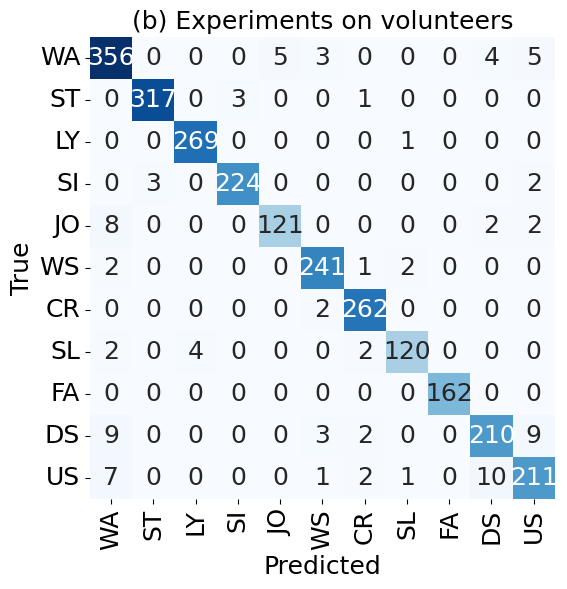

,Activity,Acc,Sen,Spe,Pre,F1
0,WA,98.3,95.4,98.7,92.7,94.1
1,ST,99.7,98.8,99.9,99.1,98.9
2,LY,99.8,99.6,99.8,98.5,99.1
3,SI,99.7,97.8,99.9,98.7,98.2
4,JO,99.3,91.0,99.8,96.0,93.4
5,WS,99.5,98.0,99.6,96.4,97.2
6,CR,99.6,99.2,99.7,97.0,98.1
7,SL,99.5,93.8,99.8,96.8,95.2
8,FA,100.0,100.0,100.0,100.0,100.0
9,DS,98.5,90.1,99.3,92.9,91.5


In [114]:
# Data from the confusion matrix
dataRT = [
    [356, 0, 0, 0, 5, 3, 0, 0, 0, 4, 5],
    [0, 317, 0, 3, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 269, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 3, 0, 224, 0, 0, 0, 0, 0, 0, 2],
    [8, 0, 0, 0, 121, 0, 0, 0, 0, 2, 2],
    [2, 0, 0, 0, 0, 241, 1, 2, 0, 0, 0],
    [0, 0, 0, 0, 0, 2, 262, 0, 0, 0, 0],
    [2, 0, 4, 0, 0, 0, 2, 120, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 162, 0, 0],
    [9, 0, 0, 0, 0, 3, 2, 0, 0, 210, 9],
    [7, 0, 0, 0, 0, 1, 2, 1, 0, 10, 211]
]
# Create DataFrame
confusion_matrix_df = pd.DataFrame(dataRT, index=class_names, columns=class_names)
# Plot confusion matrix using seaborn heatmap without the color bar (scale)
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix_df, annot=True, fmt="d", cmap="Blues",
            xticklabels=confusion_matrix_df.columns, yticklabels=confusion_matrix_df.index,
            cbar=False, annot_kws={"size": 18})
# Set labels and title with font size 14
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True', fontsize=18)
plt.title('(b) Experiments on volunteers',fontsize=18)
# Rotate x-axis labels by 30 degrees
plt.xticks(rotation=90, fontsize=18)
plt.yticks(rotation=0, fontsize=18)
# Show plot
plt.show()
calculate_metrics_class(dataRT,class_names)

In [407]:
try:
# # Ghi kết quả vào file CSV
#     joblib.dump(total_model, _dir+'total_model.pkl')
#     results_model.to_csv(_dir+"results_model.csv", index=False)
    # joblib.dump(dfresultDelFeature, _dir+'dfresultDelFeature.pkl')
    # joblib.dump(sRF_new, _dir+'random_forest_model.pkl')   #model tối ưu tham số nhưng chưa tối ưu đặc trưng
#     joblib.dump(train_features, _dir+'train_features.pkl')
#     joblib.dump(test_features, _dir+'test_features.pkl')
#     joblib.dump(label_test, _dir+'label_test_Server.pkl')
#     joblib.dump(label_train, _dir+'label_train_Server.pkl')
    # joblib.dump(best_params, _dir+'best_params.pkl')
#     joblib.dump(final_features, _dir+'final_features.pkl') #danh sách đặc trưng tối ưu
#     joblib.dump(X_train_reduced, _dir+'X_train_reduced.pkl')
#     joblib.dump(X_test_reduced, _dir+'X_test_reduced.pkl')

except Exception as e:
    print(f"Không thể ghi file CSV. Lỗi: {e}")

In [ ]:
# output model
from micromlgen import port
sRF_new
c_code = port(sRF_new, classmap = {
    0: 'walking',
    1: 'Standing',
    2: 'Lying',
    3: 'Sitting',
    4: 'Jogging',
    5: 'WalkStoop',
    6: 'Crawling',
    7: 'Slithering',
    8: 'Falling',
    9: 'Downstair',
    10: 'Upstair'
})

# Bước 3: Ghi ra file .h
with open(_dir+"RandomForestModel.h", "w") as f:
    f.write(c_code)